# Essais : RFM - KMEANS - DBSCAN - AgglomerativeClustering

# sommaire


- **1. Importation des librairies**

- **2. Datasets Commandes et clients** 

- **3. Application du modèle RFM**


- **4. Application des modèles clustering à l'ensemble des données**

-   4.1. Recherche des meilleurs hyperparamètres (Kmeans)
-   4.1. Recherche des meilleurs hyperparamètres (DBSCAN)
-   4.1. Recherche des meilleurs hyperparamètres (Hierarchical Clustering)


- **5. Application du modèle KMEANS**
-   5.1. Pipelines de modélisation
-   5.2. Segmentation selon le comportement des clients (Kmeans)
-   5.3. Heatmap Kmeans


- **5. Test de stabilité des modèles**

-   5.1. Dataframe de départ
-   5.2. Calcul du coefficient ARI
-   6.3. Comparaison de la stabilité des clusters



***

# 1 - Importation des librairies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

# 2 - Datasets Commandes et Clients

## 2.1 - Importation des données

In [4]:
# Importation des données
df_customers = pd.read_csv('olist_customers_dataset.csv', usecols=['customer_id',
                                                                   'customer_unique_id',
                                                                   'customer_state'])

df_orders = pd.read_csv('olist_orders_dataset.csv', usecols=['order_id', 'customer_id',
                                                             'order_status',
                                                             'order_purchase_timestamp',
                                                             'order_approved_at',
                                                             'order_delivered_customer_date',
                                                             'order_estimated_delivery_date'])

df_order_items = pd.read_csv('olist_order_items_dataset.csv', usecols=['order_id', 'price',
                                                                       'product_id',
                                                                       'order_item_id'])

df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', usecols=[
                               'order_id', 'review_score'])

df_order_payments = pd.read_csv('olist_order_payments_dataset.csv', usecols=[
                                'order_id', 'payment_value'])

## 2.2 - Regroupement des données utiles

In [5]:
# Jointure des données
df_1 = [df_orders, df_order_items, df_order_reviews, df_order_payments]
all_df = reduce(lambda left, right: pd.merge(
    left, right, on='order_id', how='outer'), df_1)
all_df = pd.merge(all_df, df_customers, on='customer_id', how='outer')

# Filtre des commandes annulées
all_df = all_df[(all_df.order_status != 'canceled') &
                (all_df.order_status != 'unavailable')]

# Mise au format Datetime des colonnes de dates
variables_temps = ['order_approved_at',
                   'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in variables_temps:
    all_df[i] = pd.to_datetime(all_df[i], errors='coerce').dt.normalize()

# Création d'une colonne temps de livraison
all_df['temps de livraison'] = (
    all_df['order_delivered_customer_date'] - all_df['order_approved_at']).dt.days

# Pour certaines valeurs, le temps de livraison est négatif
all_df['temps de livraison'] = np.where(
    all_df['temps de livraison'] < 0, 0, all_df['temps de livraison'])

all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117741 entries, 0 to 119142
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117741 non-null  object        
 1   customer_id                    117741 non-null  object        
 2   order_status                   117741 non-null  object        
 3   order_purchase_timestamp       117741 non-null  object        
 4   order_approved_at              117721 non-null  datetime64[ns]
 5   order_delivered_customer_date  115715 non-null  datetime64[ns]
 6   order_estimated_delivery_date  117741 non-null  datetime64[ns]
 7   order_item_id                  117733 non-null  float64       
 8   product_id                     117733 non-null  object        
 9   price                          117733 non-null  float64       
 10  review_score                   116778 non-null  float64       
 11  

## 2.3 - Detection et suppression des outliers

In [6]:
from sklearn.neighbors import LocalOutlierFactor


def supp_outliers_univaries(dataframe):
 # exclusion du centile le plus extreme

    # valeurs extremes
    index_nan = []
    index_nan_flat = []
    for column in dataframe.select_dtypes(include=['int32', 'float64']).columns.tolist():

        index_nan.append(dataframe.loc[dataframe[column] > dataframe[
            column].quantile(0.99)].index.tolist())
        index_nan.append(dataframe.loc[dataframe[column] < dataframe[
            column].quantile(0.01)].index.tolist())

    for sublist in index_nan:
        for item in sublist:
            index_nan_flat.append(item)

    # suppression des doublons
    index_nan_flat = list(dict.fromkeys(index_nan_flat))
    dataframe[column].loc[index_nan_flat] = np.nan

    return dataframe.dropna(axis=0)


def supp_outliers_multivaries(dataframe):
    # Suppression des outliers multivariés

    lof = LocalOutlierFactor(n_neighbors=5, n_jobs=-1)
    lof.fit_predict(dataframe.select_dtypes(['float64', 'int32']).dropna())
    indices = dataframe.select_dtypes(['float64', 'int32']).dropna().index
    df_lof = pd.DataFrame(index=indices,
                          data=lof.negative_outlier_factor_, columns=['lof'])
    index_to_drop = df_lof[df_lof['lof'] < np.quantile(
        lof.negative_outlier_factor_, 0.01)].index
    return dataframe.drop(index_to_drop, axis=0)


def clean_dataset(dataframe):
    dataframe = supp_outliers_univaries(dataframe)

    dataframe = supp_outliers_multivaries(dataframe)
    return dataframe

In [7]:
# Nettoyage des outliers
print('Taille du jeu de données pré-nettoyage outliers : ', all_df.shape)
all_df = clean_dataset(all_df)
print('Taille du jeu de données post-nettoyage outliers : ', all_df.shape)

Taille du jeu de données pré-nettoyage outliers :  (117741, 15)


/var/folders/__/sl6gcy7s7r9d0cg0vj7xhw800000gn/T/ipykernel_4420/2484188642.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column].loc[index_nan_flat] = np.nan


Taille du jeu de données post-nettoyage outliers :  (108116, 15)


In [6]:
all_df.to_csv('new_all_df.csv')

In [8]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108116 entries, 0 to 119142
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108116 non-null  object        
 1   customer_id                    108116 non-null  object        
 2   order_status                   108116 non-null  object        
 3   order_purchase_timestamp       108116 non-null  object        
 4   order_approved_at              108116 non-null  datetime64[ns]
 5   order_delivered_customer_date  108116 non-null  datetime64[ns]
 6   order_estimated_delivery_date  108116 non-null  datetime64[ns]
 7   order_item_id                  108116 non-null  float64       
 8   product_id                     108116 non-null  object        
 9   price                          108116 non-null  float64       
 10  review_score                   108116 non-null  float64       
 11  

## 2.4 - Dataset Commandes par client

In [9]:
# Création du jeu de données par clients et par commande

df_Commandes_Clients = all_df[['customer_unique_id',
                               'order_id',
                               'temps de livraison',
                               'review_score',
                               'order_approved_at',
                               'product_id',
                               'payment_value'
                               ]]\
    .groupby(['customer_unique_id', 'order_id'])\
    .agg({'temps de livraison': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'order_approved_at': 'max',
          'product_id': 'count',
          'payment_value': 'sum'})

df_Commandes_Clients = df_Commandes_Clients.reset_index()

In [10]:
df_Commandes_Clients.to_csv('df_Commandes_Clients.csv')

## 2.5 - Dataset Clients

In [12]:
# Création du jeu de données par clients
df_clients = df_Commandes_Clients.groupby('customer_unique_id')\
    .agg({'temps de livraison': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'product_id': 'mean',
          'payment_value': 'sum'}).round(2)

df_clients.columns = ['temps_de_livraison',
                      'note_moyenne_client',
                      'premiere_commande',
                      'nb_articles',
                      'depenses_totales']

# Date de la dernière commande
df_clients['derniere_commande'] = df_Commandes_Clients.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Récence (date du jour - date du dernier achat)
df_clients['recence'] = (
    df_clients["derniere_commande"].max() - df_clients['derniere_commande']).dt.days

# nombre de commande totale
df_clients['nb_commandes'] = df_Commandes_Clients.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# nombre moyen d'article par panier
# df_clients['nb_articles'] = df_Commandes_Clients.groupby(
# 'customer_unique_id').agg({'product_id': 'mean'}).round(2)


df_clients = df_clients.reset_index('customer_unique_id')

In [49]:
df_clients.to_csv('df_clients.csv') 

In [13]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89122 entries, 0 to 89121
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_unique_id   89122 non-null  object        
 1   temps_de_livraison   89122 non-null  float64       
 2   note_moyenne_client  89122 non-null  float64       
 3   premiere_commande    89122 non-null  datetime64[ns]
 4   nb_articles          89122 non-null  float64       
 5   depenses_totales     89122 non-null  float64       
 6   derniere_commande    89122 non-null  datetime64[ns]
 7   recence              89122 non-null  int64         
 8   nb_commandes         89122 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 6.1+ MB


In [11]:
df_clients.sample(20)

,customer_unique_id,temps_de_livraison,note_moyenne_client,premiere_commande,nb_articles,depenses_totales,derniere_commande,recence,nb_commandes
43467,7cc23ec3506e4e1e67d0702da04a734c,13.5,4.0,2017-03-27,1.0,248.91,2017-07-05,420,2
41847,7828a4a1ee004bbe6665cbffbc4bf2d9,10.5,5.0,2017-04-21,1.0,309.10,2018-02-12,198,2
38717,6f14e7220dd419f2659f0aaf9430d9af,16.0,4.0,2018-01-18,1.0,169.49,2018-01-18,223,1
30263,56cadfbcce7a707b158951162eca579c,8.0,4.0,2017-06-08,1.0,106.37,2017-06-08,447,1
40390,73e271fccfec74f2ecb75f9b05802f84,18.0,5.0,2018-02-02,1.0,55.09,2018-02-02,208,1
56100,a116036ad9da1e3e370a467c4e325250,18.0,1.0,2018-01-08,1.0,212.02,2018-01-08,233,1
42279,795ec127906a9e161109399a70f5826d,14.0,5.0,2017-04-27,1.0,50.86,2017-04-27,489,1
85539,f589582f398e43a5d9bb98c7da598ed6,4.0,1.0,2017-11-24,1.0,65.71,2017-11-24,278,1
20494,3aabcd46c57fb8f84030d1c1e7962bf7,27.0,3.0,2018-06-06,1.0,77.99,2018-06-06,84,1
5345,0f4435f8973c32a5ffe9fd128d096561,23.0,1.0,2017-08-05,1.0,178.84,2017-08-05,389,1


In [12]:
df_clients.columns

Index(['customer_unique_id', 'temps_de_livraison', 'note_moyenne_client',
       'premiere_commande', 'nb_articles', 'depenses_totales',
       'derniere_commande', 'recence', 'nb_commandes'],
      dtype='object')

# 3 - Application du modèle RFM

In [14]:
# rename the columns
df = df_clients.copy()

In [15]:
df = df.rename(columns={'nb_commandes': 'frequence',
               'depenses_totales': 'montant'})

In [16]:
RFM = df[["customer_unique_id",'recence', 'frequence', 'montant']] 

- ## RFM quartiles
La manière la plus simple de créer des segments de clients à partir du modèle RFM est d'utiliser les quartiles. Nous attribuons un score de 1 à 4 pour la récence, la fréquence et la valeur monétaire. Quatre est la meilleure/valeur la plus élevée et un est la plus mauvaise/valeur la plus basse. Un score final RFM est calculé simplement en combinant les chiffres de score individuels RFM.

In [16]:
RFM.head(3)

,customer_unique_id,recence,frequence,montant
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22


In [17]:
# Quantiles :

quantiles = RFM[['recence',
                 'frequence',
                 'montant']].quantile([.2, .4, .6, .8])
quantiles

,recence,frequence,montant
0.2,90.0,1.0,56.220
0.4,176.0,1.0,89.880
0.6,267.0,1.0,138.986
0.8,381.0,1.0,230.738


- ## Table de Segmentation RFM
- Notons qu'une valeur elevée de recenc est mauvaise 
- Les valeurs elevées de frequency et monetary sont meilleures

In [18]:
def r_score(x):
    if x <= quantiles['recence'][.2]:
        return 5
    elif x <= quantiles['recence'][.4]:
        return 4
    elif x <= quantiles['recence'][.6]:
        return 3
    elif x <= quantiles['recence'][.8]:
        return 2
    else:
        return 1


def fm_score(x, c):
    if x <= quantiles[c][.2]:
        return 1
    elif x <= quantiles[c][.4]:
        return 2
    elif x <= quantiles[c][.6]:
        return 3
    elif x <= quantiles[c][.8]:
        return 4
    else:
        return 5

In [19]:
# Scores pour R, F et M :

RFM_RFM = RFM.copy()

RFM_RFM['R'] = RFM_RFM['recence'].apply(lambda x: r_score(x))
RFM_RFM['F'] = RFM_RFM['frequence'].apply(lambda x: fm_score(x, 'frequence'))
RFM_RFM['M'] = RFM_RFM['montant'].apply(lambda x: fm_score(x, 'montant'))

- ## Ajout score RFM

In [28]:
RFM_RFM_RFMscore = RFM_RFM.copy()

In [29]:
RFM_RFM_RFMscore['RFMScore'] = RFM_RFM_RFMscore.R.map(str) + RFM_RFM_RFMscore.F.map(str) + RFM_RFM_RFMscore.M.map(str)
RFM_RFM_RFMscore.head()


,customer_unique_id,recence,frequence,montant,R,F,M,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4,1,1,411
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214


In [30]:
RFM_RFM_RFMscore_segment = RFM_RFM_RFMscore.copy()

In [31]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Big Spenders',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

RFM_RFM_RFMscore_segment['RFM_segment'] = RFM_RFM_RFMscore_segment['R'].map(
    str) + RFM_RFM_RFMscore_segment['F'].map(str)
RFM_RFM_RFMscore_segment['RFM_segment'] = RFM_RFM_RFMscore_segment['RFM_segment'].replace(
    segt_map, regex=True)

In [32]:
RFM_RFM_RFMscore_segment.sample(5)

,customer_unique_id,recence,frequence,montant,R,F,M,RFMScore,RFM_segment
78170,e031118eb65330b4c180522f2743cf51,452,2,280.33,1,5,5,155,Big Spenders
63421,b61616cdec52a901be1862d0b7f25a5c,71,1,137.41,5,1,3,513,New Customers
76368,db07fd2ad9869f8356b1fbeefdac31e8,158,3,520.48,4,5,5,455,Loyal Customers
27466,4ece3c23c89ab319574f257763c717a1,575,1,118.03,1,1,3,113,Hibernating
24168,4561d997178b39b27c642f0d23e0702a,290,1,136.47,2,1,3,213,Hibernating


- ## Visualisation des clusters

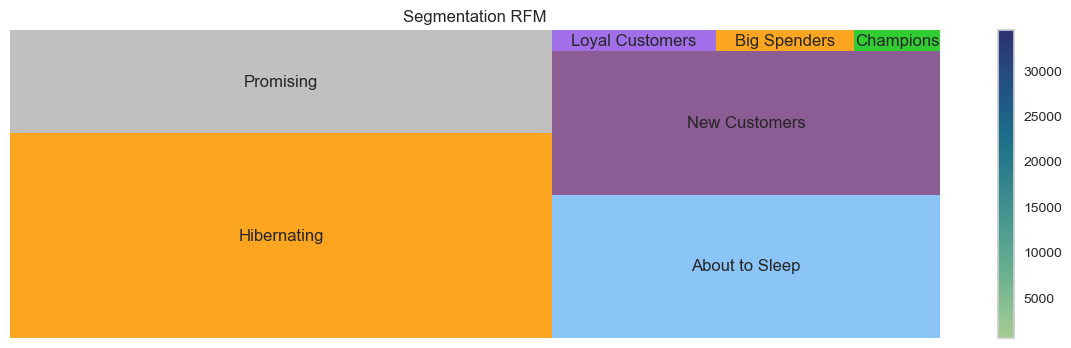

In [33]:
import matplotlib.pyplot as plt
import matplotlib
import squarify

colors = ['#fba521', 'Silver', '#8bc4f6', '#8c5c94',
          '#a170e8', '#fba521', '#32CD32', '#FF0000',
          '#32CD32', 'Silver', '#FF0000', '#fba521']

quarify_plot = RFM_RFM_RFMscore_segment.groupby('RFM_segment')[
    'customer_unique_id'].nunique().sort_values(ascending=False).reset_index()

mini = min(quarify_plot['customer_unique_id'])
maxi = max(quarify_plot['customer_unique_id'])

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 4)
squarify.plot(sizes=quarify_plot['customer_unique_id'],
              label=quarify_plot.RFM_segment, alpha=1,
              color=colors)

plt.axis('off')
plt.title("Segmentation RFM", fontsize=12)
ttl = ax.title
ttl.set_position([.5, 1.05])

# Set the colormap directly using the `color` argument
cmap = matplotlib.cm.get_cmap('crest')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=mini, vmax=maxi))
cbar = plt.colorbar(sm)

plt.show()

- Concentrez vos efforts marketing sur les groupes de clients les plus importants ou les plus rentables, comme les **"Big Spenders"**, les **"Loyal Customers"** et les **"Champions"**.

- Prenez des mesures pour réactiver les clients **"Hibernating"** ou **"About to Sleep"** en leur offrant des promotions ou des remises spéciales pour les inciter à acheter à nouveau.

- Les clients **"New Customers"** et **"Potential Loyalists"** sont des clients à fort potentiel pour votre entreprise. Offrez-leur des avantages pour les encourager à devenir des clients fidèles à long terme.

- Les clients **"Promising"** peuvent être encouragés à acheter plus fréquemment en leur offrant des incitations à l'achat ou des programmes de fidélité.

# 4 - Application des modèles de clustering à l'ensemble des données

## 4.1 - Pipeline de pre-processing

In [17]:
df_clients.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89122 entries, 0 to 89121
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_unique_id   89122 non-null  object        
 1   temps_de_livraison   89122 non-null  float64       
 2   note_moyenne_client  89122 non-null  float64       
 3   premiere_commande    89122 non-null  datetime64[ns]
 4   nb_articles          89122 non-null  float64       
 5   depenses_totales     89122 non-null  float64       
 6   derniere_commande    89122 non-null  datetime64[ns]
 7   recence              89122 non-null  int64         
 8   nb_commandes         89122 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 6.1+ MB


In [18]:
df_clients.isna().sum()

customer_unique_id     0
temps_de_livraison     0
note_moyenne_client    0
premiere_commande      0
nb_articles            0
depenses_totales       0
derniere_commande      0
recence                0
nb_commandes           0
dtype: int64

- ### **Normalisation des données**

In [19]:
# Pre-processing

# définition d'une liste de noms de colonnes qui correspondent
# à des variables numériques non-transformées.
features = ['note_moyenne_client',
            'nb_commandes',
            'nb_articles']

# définition d'une liste de noms de colonnes qui correspondent
# à des variables numériques qui seront transformées à l'aide
# d'une fonction de transformation logarithmique.
log_features = ['temps_de_livraison',
                'depenses_totales',
                'recence']

# création d'un objet Pipeline qui contient deux étapes de
# prétraitement (scaler) pour les variables features.
features_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# création d'un objet Pipeline qui contient trois étapes de
# prétraitement (logTransformation, et scaler) pour les
# variables log_features.
logfeatures_transformer = Pipeline(
    steps=[("logTransformation", FunctionTransformer(
        lambda value: np.log1p(value))),
        ("scaler", StandardScaler())]
)

# création d'un objet ColumnTransformer qui applique les
# transformateurs spécifiés (features_transformer et
# logfeatures_transformer) à leurs colonnes
# correspondantes dans le jeu de données.
preprocessor = ColumnTransformer(
    remainder='drop',
    transformers=[
        ("features", features_transformer, features),
        ("log_features", logfeatures_transformer, log_features),
    ]
)

In [20]:
# la méthode fit_transform() du pipeline de pré-traitement (preprocessor) est
# appliquée sur les données de ces clients sélectionnés. Cette méthode effectue
# deux étapes de pré-traitement : l'imputation des valeurs manquantes et la mise à
# l'échelle des données. Le résultat de fit_transform() est un tableau de données
# numpy avec les colonnes pré-traitées. Ce tableau est transformé en un DataFrame
# pandas et les noms de colonnes sont définis à l'aide des listes features et
# log_features définies précédemment :

scaled_df_commandes = pd.DataFrame(preprocessor.fit_transform(df_clients),
                                   columns=[*features+log_features])

In [19]:
print(df_clients.shape) 
print(scaled_df_commandes.shape)

(89122, 9)
(89122, 6)


In [20]:
scaled_df_commandes.head()

,note_moyenne_client,nb_commandes,nb_articles,temps_de_livraison,depenses_totales,recence
0,0.657173,-0.15775,-0.296902,-0.657691,0.201373,-0.455579
1,-0.136677,-0.15775,-0.296902,-1.573079,-1.700665,-0.427815
2,-0.930528,-0.15775,-0.296902,1.550444,-0.377157,1.192804
3,-0.136677,-0.15775,-0.296902,1.139358,-1.162557,0.653650
4,0.657173,-0.15775,-0.296902,0.476121,0.582871,0.540081


- ## Recherche hyperparamètres du Modèle Kmeans

**Le Kmeans est un algorithm utilisé pour la classification et la segmentation de 
données en groupes ou en clusters. Il est basé sur la minimisation de la somme des 
distances euclidiennes entre les points de données et leurs centres de cluster.**
- Détermine le nombre de clusters K que vous souhaitez créer.
- Sélectionne K points de données au hasard pour servir de centres de cluster initiaux.
- Attribue chaque point de données au centre de cluster le plus proche en termes de distance euclidienne.
- Calcule la moyenne de chaque cluster et déplace le centre du cluster vers cette moyenne.
- Répéte les étapes 3 et 4 jusqu'à ce que les centres de cluster convergent vers une position stable.

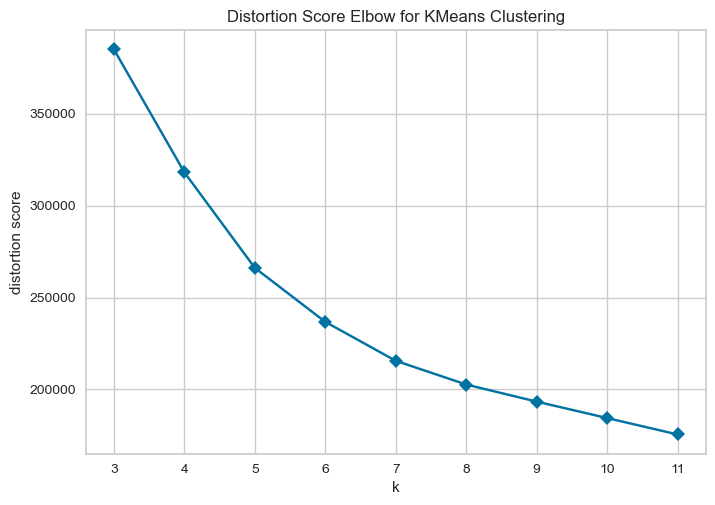

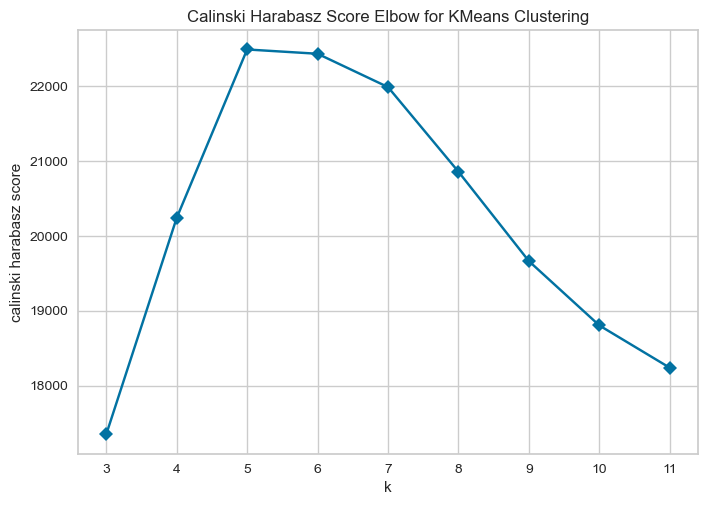

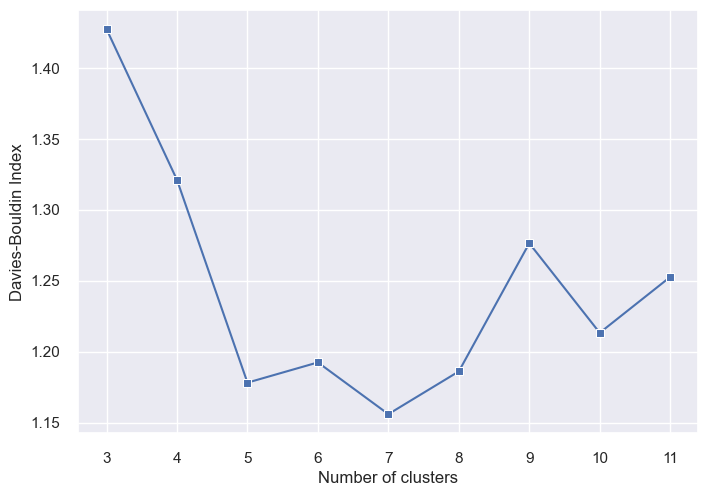

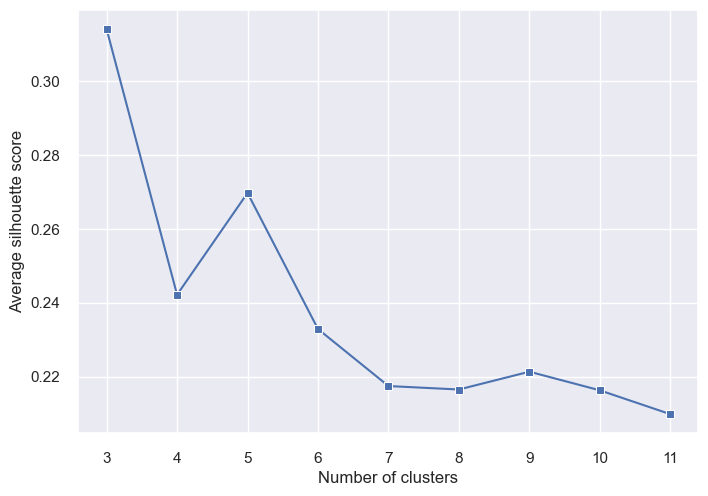

In [21]:
# initialiser le modèle K-means avec une graine aléatoire et créer deux
# listes vides pour stocker les résultats des métriques :

model = KMeans(random_state=42)
db_index = []
sil = []

# Création d'un objet de visualisation KElbowVisualizer pour afficher
# l'indice de coude pour différents nombres de clusters à utiliser.
# La méthode fit() du visualizer est utilisée pour adapter
# les données (scaled_df_achats) au modèle K-means et afficher la visualisation :

visualizer = KElbowVisualizer(
    model, k=(3, 12), timings=False, locate_elbow=False)

visualizer.fit(scaled_df_commandes)    # Fit the data to the visualizer
#plt.figure(figsize=(10, 10))

visualizer.show()

# un autre objet de visualisation KElbowVisualizer est créé pour afficher
# le score de Calinski-Harabasz pour différents nombres de clusters.
# La méthode fit() est utilisée pour adapter les données et
# afficher la visualisation :
visualizer = KElbowVisualizer(
    model, k=(3, 12), metric='calinski_harabasz', timings=False, locate_elbow=False)

visualizer.fit(scaled_df_commandes)    # Fit the data to the visualizer
visualizer.show()

# une boucle est utilisée pour ajuster le modèle K-means pour différents
# nombres de clusters, à partir de 3 et jusqu'à 11 inclus. Dans chaque
# itération, les données sont ajustées (fit()) au modèle K-means,
# les étiquettes des clusters sont prédites pour chaque observation (predict())
# et les métriques de Davies-Bouldin et de score de silhouette sont calculées
# et stockées dans les listes db_index et sil, respectivement :
for k in range(3, 12):
    kmeans = KMeans(n_clusters=k,  random_state=0)
    kmeans.fit(scaled_df_commandes)
    labels = kmeans.predict(scaled_df_commandes)
    sil_T = silhouette_score(scaled_df_commandes, labels, sample_size=5000)
    sil.append(sil_T)
    db_index_t = davies_bouldin_score(scaled_df_commandes, labels)
    db_index.append(db_index_t)

# deux graphiques sont tracés pour chaque métrique en utilisant les listes
# db_index et sil. Les valeurs de la métrique sont tracées sur l'axe des ordonnées
# et le nombre de clusters est tracé sur l'axe des abscisses.

sns.set_theme(style="darkgrid")

sns.lineplot(x=range(3, 12), y=db_index,
             marker="s", dashes=False)
plt.xticks(range(3, 12))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin Index")
plt.show()

sns.lineplot(x=range(3, 12), y=sil,
             marker="s", dashes=False)
plt.xticks(range(3, 12))
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.show()

- ## Plus de details

In [63]:
from sklearn import metrics
silhouette_scores = []
davies_bouldin_scores = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df_commandes)
    kmeans_labels = kmeans.labels_
    kmeans_pred = kmeans.predict(scaled_df_commandes)

    kmeans_score_sil = metrics.silhouette_score(
        scaled_df_commandes, kmeans_labels)
    silhouette_scores.append(kmeans_score_sil)

    kmeans_score_db = metrics.davies_bouldin_score(
        scaled_df_commandes, kmeans_labels)
    davies_bouldin_scores.append(kmeans_score_db)

    print("For k =", k, "Silhouette Coefficient: %0.3f" % kmeans_score_sil,
          "Davies Bouldin score: %0.3f" % kmeans_score_db)

For k = 2 Silhouette Coefficient: 0.317 Davies Bouldin score: 1.969
For k = 3 Silhouette Coefficient: 0.211 Davies Bouldin score: 1.618
For k = 4 Silhouette Coefficient: 0.237 Davies Bouldin score: 1.326
For k = 5 Silhouette Coefficient: 0.274 Davies Bouldin score: 1.178
For k = 6 Silhouette Coefficient: 0.230 Davies Bouldin score: 1.192
For k = 7 Silhouette Coefficient: 0.222 Davies Bouldin score: 1.156
For k = 8 Silhouette Coefficient: 0.222 Davies Bouldin score: 1.186
For k = 9 Silhouette Coefficient: 0.222 Davies Bouldin score: 1.277
For k = 10 Silhouette Coefficient: 0.212 Davies Bouldin score: 1.202
For k = 11 Silhouette Coefficient: 0.209 Davies Bouldin score: 1.237


- ## Recherche hyperparamètres du Modèle DBSCAN

Text(0, 0.5, 'Distances des 7-NN')

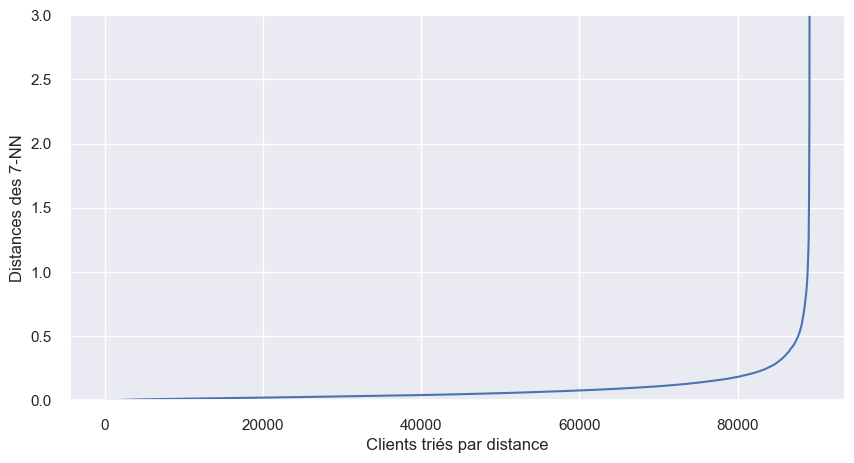

In [22]:
from sklearn.neighbors import NearestNeighbors


neigh = NearestNeighbors(n_neighbors=7)
nbrs = neigh.fit(scaled_df_commandes)
distances, indices = nbrs.kneighbors(scaled_df_commandes)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.ylim(0, 3)
plt.xlabel("Clients triés par distance")
plt.ylabel("Distances des 7-NN")

In [ ]:
from sklearn.cluster import DBSCAN

ch_index = []
db_index = []
sil = []
n_clusters_ = []
n_noise_ = []

for i in np.arange(0.3, 3, 0.2):
    Birch_model = DBSCAN(eps=i, min_samples=7)
    labels = Birch_model.fit_predict(scaled_df_commandes)

    n_clusters_t = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_.append(n_clusters_t)

    n_noise_t = list(labels).count(-1)
    n_noise_.append(n_noise_t)

    sil_T = silhouette_score(scaled_df_commandes, labels, sample_size=5000)
    sil.append(sil_T)

    db_index_t = davies_bouldin_score(scaled_df_commandes, labels)
    db_index.append(db_index_t)

    ch_index_t = calinski_harabasz_score(scaled_df_commandes, labels)
    ch_index.append(ch_index_t)


plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=n_clusters_,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Estimated number of clusters")
plt.show()

plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=n_noise_,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Estimated number of noise points")
plt.show()


plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=ch_index,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Calinski Harabasz score")
plt.show()


plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=db_index,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Davies-Bouldin Index")
plt.show()

plt.figure(figsize=(10, 5))

sns.lineplot(x=np.arange(0.3, 3, 0.2), y=sil,
             marker="s", dashes=False)
plt.xticks(np.arange(0.3, 3, 0.2))
plt.xlabel("Epsilon Value")
plt.ylabel("Average silhouette score")
plt.show()

- ## Recherche hyperparamèetres Hierachical Clustering

In [21]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(compute_distances=True)
label = model.fit_predict(scaled_df_commandes)

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(20, 5))
plot_dendrogram(model, truncate_mode="level", p=6)
ax.xaxis.set_tick_params(labelsize=10)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plt.xlabel("Number de points du voisinage.")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Initialisation du modèle avec 6 clusters
model = AgglomerativeClustering(n_clusters=6)

# Prédiction des clusters pour les données d'entrée
labels = model.fit_predict(scaled_df_commandes)

# Calcul des liens de la hiérarchie

linkage_matrix = linkage(pdist(scaled_df_commandes), method='ward')

# Création du dendrogramme
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, color_threshold=0, truncate_mode='level',
           p=6, leaf_font_size=10, labels=labels)
plt.xlabel("Points de données")
plt.ylabel("Distance")
plt.title("Dendrogramme avec 6 clusters")
plt.show()

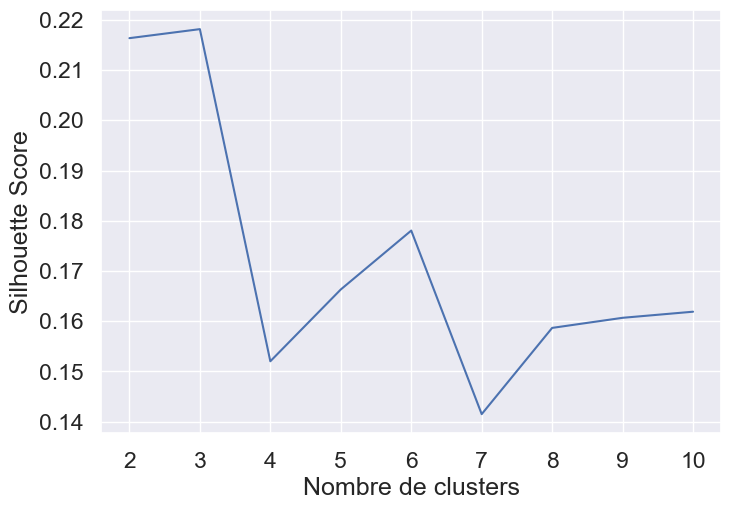

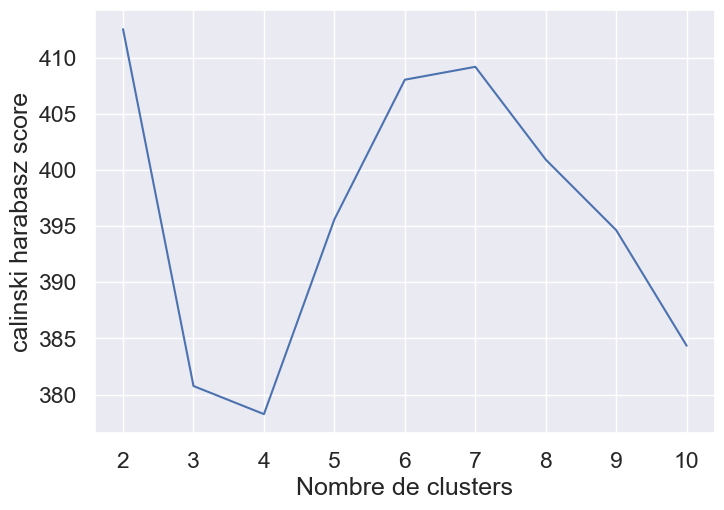

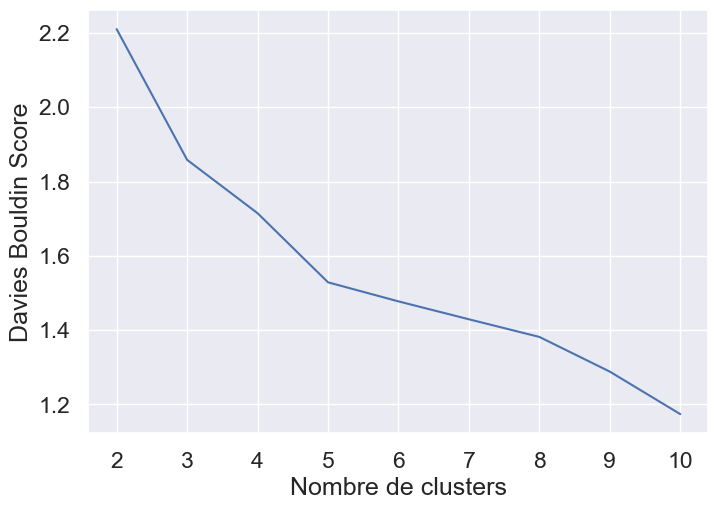

In [87]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import seaborn as sns
import matplotlib.pyplot as plt

# Créer l'estimateur AgglomerativeClustering
agg_clustering = AgglomerativeClustering()

# Définir le nombre de clusters à évaluer
n_clusters_range = range(2, 11)

# Initialiser les listes pour stocker les scores de silhouette et de Davies Bouldin
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Boucle sur le nombre de clusters pour calculer les scores
for n_clusters in n_clusters_range:
    agg_clustering.set_params(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(scaled_df_commandes)
    silhouette_scores.append(silhouette_score(scaled_df_commandes, labels))
    davies_bouldin_scores.append(
        davies_bouldin_score(scaled_df_commandes, labels))
    calinski_harabasz_scores.append(
        calinski_harabasz_score(scaled_df_commandes, labels))

# Tracer le graphe de silhouette score en fonction du nombre de clusters
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tracer le graphe de Davies Bouldin en fonction du nombre de clusters
plt.plot(n_clusters_range, calinski_harabasz_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('calinski harabasz score')
plt.show()

# Tracer le graphe de Davies Bouldin en fonction du nombre de clusters
plt.plot(n_clusters_range, davies_bouldin_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

# 5 - Application du modèle KMEANS avec k=5

In [22]:
# Clustering :
dataset_clients_sans_dates = df_clients.copy()

In [23]:
dataset_clients_sans_dates.columns

Index(['customer_unique_id', 'temps_de_livraison', 'note_moyenne_client',
       'premiere_commande', 'nb_articles', 'depenses_totales',
       'derniere_commande', 'recence', 'nb_commandes'],
      dtype='object')

In [24]:
dataset_clients_sans_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89122 entries, 0 to 89121
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_unique_id   89122 non-null  object        
 1   temps_de_livraison   89122 non-null  float64       
 2   note_moyenne_client  89122 non-null  float64       
 3   premiere_commande    89122 non-null  datetime64[ns]
 4   nb_articles          89122 non-null  float64       
 5   depenses_totales     89122 non-null  float64       
 6   derniere_commande    89122 non-null  datetime64[ns]
 7   recence              89122 non-null  int64         
 8   nb_commandes         89122 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 6.1+ MB


In [25]:
dataset_clients_sans_dates.drop(columns=['premiere_commande',
                                         'derniere_commande'], inplace=True)

In [26]:
dataset_clients_sans_dates.set_index('customer_unique_id', inplace=True)

In [27]:
dataset_clients_sans_dates.head()

,temps_de_livraison,note_moyenne_client,nb_articles,depenses_totales,recence,nb_commandes
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,5.0,1.0,141.90,111,1
0000b849f77a49e4a4ce2b2a4ca5be3f,3.0,4.0,1.0,27.19,114,1
0000f46a3911fa3c0805444483337064,26.0,3.0,1.0,86.22,537,1
0000f6ccb0745a6a4b88665a16c9f078,20.0,4.0,1.0,43.62,321,1
0004aac84e0df4da2b147fca70cf8255,13.0,5.0,1.0,196.89,288,1


In [28]:
kmeans = KMeans(random_state=42, n_clusters=5)
kmeans.fit(scaled_df_commandes)

dataset_clients_sans_dates['segments'] = 
kmeans.predict(scaled_df_commandes)

In [29]:
dataset_clients_sans_dates.head() 

,temps_de_livraison,note_moyenne_client,nb_articles,depenses_totales,recence,nb_commandes,segments
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,5.0,1.0,141.90,111,1,2
0000b849f77a49e4a4ce2b2a4ca5be3f,3.0,4.0,1.0,27.19,114,1,2
0000f46a3911fa3c0805444483337064,26.0,3.0,1.0,86.22,537,1,1
0000f6ccb0745a6a4b88665a16c9f078,20.0,4.0,1.0,43.62,321,1,0
0004aac84e0df4da2b147fca70cf8255,13.0,5.0,1.0,196.89,288,1,0


In [30]:
centre_clusters = pd.DataFrame(kmeans.cluster_centers_,
                               columns=scaled_df_commandes.columns).reset_index()

In [31]:
centre_clusters.head()

,index,note_moyenne_client,nb_commandes,nb_articles,temps_de_livraison,depenses_totales,recence
0,0,0.408883,-0.157750,-0.259266,0.180042,-0.169071,0.476077
1,1,-1.917462,-0.157750,-0.104275,0.758011,-0.017914,0.184072
2,2,0.347398,-0.157750,-0.221908,-0.894496,-0.271553,-1.255369
3,3,0.046727,5.273164,0.243073,0.071783,1.021812,-0.086730
4,4,-0.154043,-0.148738,2.442259,-0.065835,1.545562,0.131390


In [32]:
centre_clusters.drop(columns=['index'], inplace=True)

In [33]:
centre_clusters.head()

,note_moyenne_client,nb_commandes,nb_articles,temps_de_livraison,depenses_totales,recence
0,0.408883,-0.157750,-0.259266,0.180042,-0.169071,0.476077
1,-1.917462,-0.157750,-0.104275,0.758011,-0.017914,0.184072
2,0.347398,-0.157750,-0.221908,-0.894496,-0.271553,-1.255369
3,0.046727,5.273164,0.243073,0.071783,1.021812,-0.086730
4,-0.154043,-0.148738,2.442259,-0.065835,1.545562,0.131390


In [34]:
color_pal = sns.color_palette("crest", 5).as_hex()
colors = ','.join(color_pal)

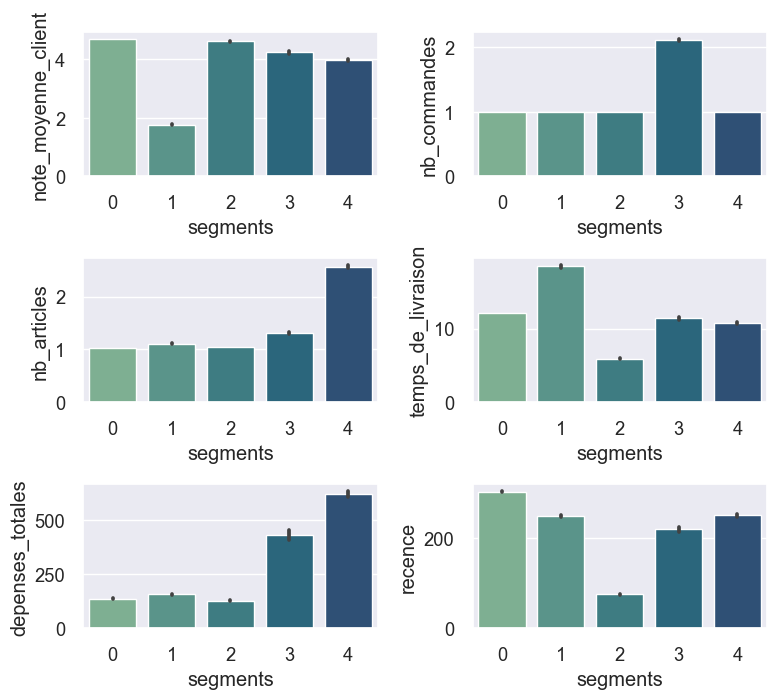

In [35]:
plt.figure(figsize=(8, 7))

sns.set(font_scale=1.2)
i = 0
for var in [*features+log_features]:
    ax = plt.subplot(3, 2, i+1)
    sns.barplot(data=dataset_clients_sans_dates,
                x='segments',
                y=var, palette=color_pal)
    i += 1
plt.tight_layout()

- **Cluster 0** : Dernier achat lointain, faibles dépenses, bonne note, temps de vraison moyen.**(Clients dormants)**
- **Cluster 1** : Dernier achat lointain, faibles dépenses, clients insatisfaits. **(Clients à risk)**
- **Cluster 2** : Dernier achat récent, faibles dépenses, livraison rapide.**(Nouveau clients)**
- **Cluster 3** : Dernier achat relativement lrécent, dépenses élevées, temps de livraison moyen. **(Argent)**
- **Cluster 4** : Dernier achat lointain, dépenses élevées, temps de livraison moyen, plus de 2 articles au panier.**(VIP)**